# Fine-tune GPT Model

- We'll be finetuning the LLM on a specific target task, such as classifying text.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from utils import go_up_from_current_directory

go_up_from_current_directory(go_up=1)
from data_prep.data_prep import DataCleaner

/Users/neidu/Desktop/Projects/Personal/My_Projects/NLP-Tutorial/notebook


### Load Data

In [4]:
fp: str = "./models/spend_df.parquet"

df: pl.DataFrame = pl.read_parquet(fp).drop(
    ["index", "date", "type", "amount", "balance", "tags"]
)
print(f"Shape of data: {df.shape} \n")

df.head()

Shape of data: (1608255, 4) 



customer_id,nuban,description,label
str,i64,str,str
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""


In [5]:
df.group_by("label").agg(pl.len()).to_pandas()

,label,len
0,loan,41454
1,bills,33312
2,savingsAndInvestments,4059
3,noSpend,1529430


In [6]:
TEXT_COLUMN: str = "description"

df = DataCleaner(data=df, text_column=TEXT_COLUMN).prepare_data()
df.to_pandas().head()

,customer_id,nuban,description,label,cleaned_text
0,33950,1,Quantum USSD,noSpend,quantum ussd
1,33950,1,Quantum USSD,noSpend,quantum ussd
2,33950,1,Quantum USSD,noSpend,quantum ussd
3,33950,1,Quantum USSD,noSpend,quantum ussd
4,33950,1,Quantum USSD,noSpend,quantum ussd


In [7]:
TEXT_COLUMN: str = "cleaned_text"
df = df.with_columns(desc_length=pl.col(TEXT_COLUMN).str.len_chars())

df.to_pandas().head()

,customer_id,nuban,description,label,cleaned_text,desc_length
0,33950,1,Quantum USSD,noSpend,quantum ussd,12
1,33950,1,Quantum USSD,noSpend,quantum ussd,12
2,33950,1,Quantum USSD,noSpend,quantum ussd,12
3,33950,1,Quantum USSD,noSpend,quantum ussd,12
4,33950,1,Quantum USSD,noSpend,quantum ussd,12


In [8]:
df.describe()

statistic,customer_id,nuban,description,label,cleaned_text,desc_length
str,str,f64,str,str,str,f64
"""count""","""1608255""",1.608255e6,"""1608255""","""1608255""","""1608255""",1.608255e6
"""null_count""","""0""",0.0,"""0""","""0""","""0""",0.0
"""mean""",null,1.0,null,null,null,32.907305
"""std""",null,0.0,null,null,null,16.400539
"""min""","""33790""",1.0,""" WASIU ABAS…","""bills""","""""",0.0
"""25%""",null,1.0,null,null,null,18.0
"""50%""",null,1.0,null,null,null,34.0
"""75%""",null,1.0,null,null,null,45.0
"""max""","""36192""",1.0,"""yunusa Badama…","""savingsAndInve…","""zuriyat ladidi…",136.0


In [9]:
text_length: int = 30

df = df.filter(pl.col("desc_length").ge(text_length))
df.describe()

statistic,customer_id,nuban,description,label,cleaned_text,desc_length
str,str,f64,str,str,str,f64
"""count""","""935136""",935136.0,"""935136""","""935136""","""935136""",935136.0
"""null_count""","""0""",0.0,"""0""","""0""","""0""",0.0
"""mean""",null,1.0,null,null,null,44.600487
"""std""",null,0.0,null,null,null,10.438947
"""min""","""33790""",1.0,""" COUNTER CHEQ…","""bills""",""" revr_rvsl_b…",30.0
"""25%""",null,1.0,null,null,null,35.0
"""50%""",null,1.0,null,null,null,43.0
"""75%""",null,1.0,null,null,null,51.0
"""max""","""36192""",1.0,"""shokunbi, esth…","""savingsAndInve…","""zulukarniani a…",136.0


In [10]:
df.group_by("label").agg(pl.len()).to_pandas()

,label,len
0,loan,33723
1,bills,14292
2,savingsAndInvestments,3729
3,noSpend,883392


In [11]:
N: int = 2_000
seed: int = 123
selected_columns: list[str] = [TEXT_COLUMN, "label"]

loan: pl.DataFrame = df.filter(pl.col("label").eq("loan")).sample(n=N, seed=seed)
noSpend: pl.DataFrame = df.filter(pl.col("label").eq("noSpend")).sample(n=N, seed=seed)
bills: pl.DataFrame = df.filter(pl.col("label").eq("bills")).sample(n=N, seed=seed)
savings: pl.DataFrame = df.filter(pl.col("label").eq("savingsAndInvestments")).sample(
    n=N,
    seed=seed,
    with_replacement=False,  # NEW!
)

data: pl.DataFrame = (
    pl.concat([loan, noSpend, bills, savings], how="vertical")
    .sample(fraction=1, seed=seed, shuffle=True)
    .select(selected_columns)
)
print(f"Shape of data: {data.shape} \n")
data.head().to_pandas()

Shape of data: (8000, 2) 



,cleaned_text,label
0,brentwood multiservices global ltd sales proceed account,bills
1,pos web pmt riquest oil gas owerrri ng,bills
2,amt includes comm vat ussd uduak etim augustine,noSpend
3,trf hay frm adekunle amos niran olaleye olabode simon,noSpend
4,pos web pmt bolt_payu lagos ng,bills


In [12]:
data.group_by("label").agg(pl.len()).to_pandas()

,label,len
0,savingsAndInvestments,2000
1,bills,2000
2,noSpend,2000
3,loan,2000


In [13]:
data = data.with_columns(desc_length=pl.col(TEXT_COLUMN).str.len_chars())

data.to_pandas().head()

,cleaned_text,label,desc_length
0,brentwood multiservices global ltd sales proceed account,bills,57
1,pos web pmt riquest oil gas owerrri ng,bills,38
2,amt includes comm vat ussd uduak etim augustine,noSpend,47
3,trf hay frm adekunle amos niran olaleye olabode simon,noSpend,54
4,pos web pmt bolt_payu lagos ng,bills,30


In [14]:
data.describe()

statistic,cleaned_text,label,desc_length
str,str,str,f64
"""count""","""8000""","""8000""",8000.0
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,41.615125
"""std""",null,null,12.585847
"""min""",""" bills payment…","""bills""",30.0
"""25%""",null,null,32.0
"""50%""",null,null,36.0
"""75%""",null,null,48.0
"""max""","""xclusiveplus a…","""savingsAndInve…",106.0


In [15]:
# Encode the labels
mappings: dict[str, int] = {
    "bills": 0,
    "loan": 1,
    "savingsAndInvestments": 2,
    "noSpend": 3,
}
data = data.with_columns(label=pl.col("label").replace(mappings).cast(pl.UInt8))

data.group_by("label").agg(pl.len())

label,len
u8,u32
0,2000
2,2000
1,2000
3,2000


In [16]:
## Split the data into tran, validation and test sets
from sklearn.model_selection import train_test_split


train_data: pl.DataFrame
val_data: pl.DataFrame
test_data: pl.DataFrame

train_data, test_data = train_test_split(
    data, stratify=data.select("label"), test_size=0.1, random_state=seed
)
train_data, val_data = train_test_split(
    train_data, stratify=train_data.select("label"), test_size=0.1, random_state=seed
)

print(f"{train_data.shape = }, {val_data.shape = }, {test_data.shape = }")

train_data.shape = (6480, 3), val_data.shape = (720, 3), test_data.shape = (800, 3)


In [17]:
class SpendDataset(Dataset):
    def __init__(
        self,
        data: pl.DataFrame,
        tokenizer: Any,
        text_column: str = "Text",
        label_column: str = "Label",
        max_length: int | None = None,
        pad_token: int = 50_256,
    ) -> None:
        self.data = data
        self.encoded_texts: list[int] = [
            tokenizer.encode(text) for text in self.data.select(text_column).to_series()
        ]

        if max_length is None:
            self.max_length: int = self._calculate_max_length()
        else:
            assert (
                max_length > 0
            ), "max_length must be a positive integer or None, not a negative integer."
            self.max_length = max_length

        # Truncate text
        self.encoded_texts = [
            tok_ids[: self.max_length] for tok_ids in self.encoded_texts
        ]
        # Pad Text
        self.encoded_texts = [
            tok_ids + [pad_token] * (self.max_length - len(tok_ids))
            for tok_ids in self.encoded_texts
        ]
        # Targets
        self.targets: list[int] = self.data.select(label_column).to_series().to_list()

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        text: Tensor = torch.tensor(self.encoded_texts[idx], dtype=torch.long)
        label: Tensor = torch.tensor(self.targets[idx], dtype=torch.long)

        return (text, label)

    def _calculate_max_length(self) -> int:
        return max([len(tok_ids) for tok_ids in self.encoded_texts])

In [18]:
# Test the dataset implementation
import tiktoken


torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
sample_dataset: Dataset = SpendDataset(
    data=train_data,
    tokenizer=tokenizer,
    text_column=TEXT_COLUMN,
    label_column="label",
)

sample_dataset[0]

(tensor([ 1930,  3992,  9114,    83,   299,   541,  1073,   458,    66,  4947,
          8591, 23370, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256]),
 tensor(3))

In [19]:
train_dataset: Dataset = SpendDataset(
    data=train_data,
    tokenizer=tokenizer,
    text_column=TEXT_COLUMN,
    label_column="label",
)
val_dataset: Dataset = SpendDataset(
    data=val_data,
    tokenizer=tokenizer,
    max_length=train_dataset.max_length,
    text_column=TEXT_COLUMN,
    label_column="label",
)
test_dataset: Dataset = SpendDataset(
    data=test_data,
    tokenizer=tokenizer,
    max_length=train_dataset.max_length,
    text_column=TEXT_COLUMN,
    label_column="label",
)

print(f"train dataset max length: {train_dataset.max_length}\n")

# Create data loaders
batch_size: int = 16
num_workers: int = 0

train_loader: DataLoader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader: DataLoader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)
test_loader: DataLoader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

train dataset max length: 41



In [20]:
for inp_batch, target_batch in train_loader:
    print(f"{inp_batch.shape = }")
    print(f"{target_batch.shape = }\n\n")

    break


print(f"{len(train_loader) = }")
print(f"{len(val_loader) = }")
print(f"{len(test_loader) = }")

inp_batch.shape = torch.Size([16, 41])
target_batch.shape = torch.Size([16])


len(train_loader) = 405
len(val_loader) = 45
len(test_loader) = 50


<hr>

### Load Pretrained Model

In [21]:
# Model Config
GPT_CONFIG_124M: dict[str, Any] = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 768,
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,
}

MODEL_CHOICE: str = "gpt2-small (124M)"
INPUT_PROMPT: str = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50_257,  # Vocabulary size
    "context_length": 1_024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-key-value bias
}
model_configs: dict[str, dict] = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[MODEL_CHOICE])

assert train_dataset.max_length <= BASE_CONFIG.get("context_length"), (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG.get('context_length')}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG.get('context_length')}`"
)

In [22]:
from gpt_download import download_and_load_gpt2
from utils import GPTModel, load_weights_into_gpt


model_size: str = MODEL_CHOICE.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(gpt=model, params=params)

2024-06-23 18:21:28.670131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


### Add Classification Head

In [23]:
# To get the model ready for fine-tuning, we need to `freeze` the model's parameters.
for param in model.parameters():
    param.requires_grad = False


# Replace the output layer which originally maps the layer inputs to 50,257 dimensions
# to the number of classes.
torch.manual_seed(seed)
num_classes: int = len(mappings)

model.out_head = nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)


# Make the last `transformer block` layer trainable
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

# Make the last `final_norm` layer trainable
for param in model.final_norm.parameters():
    param.requires_grad = True


model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inpla

#### Calculate Accuracy (Before Fine-Tuning)


In [24]:
from train_eval import *

In [25]:
print("=== BEFORE Fine Tuning ===")
torch.manual_seed(seed)

device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_accuracy: float = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy: float = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy: float = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

 === BEFORE Fine Tuning === 
Training accuracy: 24.38%
Validation accuracy: 26.25%
Test accuracy: 21.25%


In [26]:
# Similar to calculating the training accuracy, we now compute the initial loss for each data set:
print("=== BEFORE Fine Tuning ===")
with torch.no_grad():
    train_loss: float = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss: float = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss: float = calc_loss_loader(test_loader, model, device, num_batches=5)


print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

=== BEFORE Fine Tuning ===
Training loss: 2.818
Validation loss: 2.899
Test loss: 3.037


### Fine-Tune Model

In [27]:
import time


torch.manual_seed(seed)

num_epochs: int = 7
start_time: float = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
    tokenizer=tokenizer,
)

end_time: float = time.time()
execution_time_minutes: float = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.642, Val loss 2.750
Ep 1 (Step 000050): Train loss 1.386, Val loss 1.426
Ep 1 (Step 000100): Train loss 1.377, Val loss 1.375
Ep 1 (Step 000150): Train loss 1.343, Val loss 1.329
Ep 1 (Step 000200): Train loss 1.210, Val loss 1.236
Ep 1 (Step 000250): Train loss 1.103, Val loss 1.206
Ep 1 (Step 000300): Train loss 0.925, Val loss 1.035
Ep 1 (Step 000350): Train loss 0.752, Val loss 0.872
Ep 1 (Step 000400): Train loss 0.566, Val loss 0.787
Training accuracy: 63.75% | Validation accuracy: 71.25%
Ep 2 (Step 000450): Train loss 0.642, Val loss 0.705
Ep 2 (Step 000500): Train loss 0.679, Val loss 0.735
Ep 2 (Step 000550): Train loss 0.539, Val loss 0.669
Ep 2 (Step 000600): Train loss 0.602, Val loss 0.678
Ep 2 (Step 000650): Train loss 0.659, Val loss 0.722
Ep 2 (Step 000700): Train loss 0.402, Val loss 0.665
Ep 2 (Step 000750): Train loss 0.458, Val loss 0.600
Ep 2 (Step 000800): Train loss 0.616, Val loss 0.525
Training accuracy: 85.00% | Validation accu

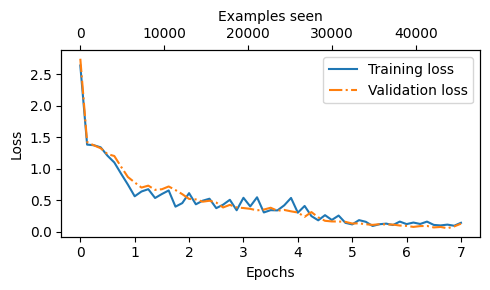

In [28]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(
    epochs_tensor, examples_seen_tensor, train_losses, val_losses, save_plot=False
)

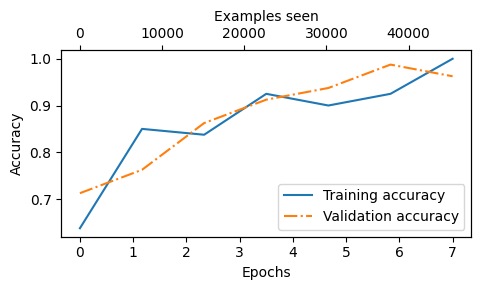

In [29]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor,
    examples_seen_tensor,
    train_accs,
    val_accs,
    label="accuracy",
    save_plot=False,
)

In [30]:
train_accuracy: float = calc_accuracy_loader(train_loader, model, device)
val_accuracy: float = calc_accuracy_loader(val_loader, model, device)
test_accuracy : float= calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.41%
Validation accuracy: 96.25%
Test accuracy: 96.75%


In [28]:
def classify_transaction(
    text: str,
    model: nn.Module,
    tokenizer: Any,
    device: str | torch.device,
    max_length: int,
    pad_token_id: int = 50256,
) -> dict[str, Any]:
    model.eval()

    labels: list[str] = ["bills", "loan", "savingsAndInvestments", "noSpend"]
    cleaned_text: str = (
        DataCleaner(data=pl.DataFrame(data={"text": text}))
        .prepare_data()
        .select(["cleaned_text"])
        .to_series()
        .to_list()[0]
    )

    input_ids: list[int] = tokenizer.encode(cleaned_text)
    supported_context_length: int = model.pos_emb.weight.shape[1]
    # Truncate the input to the maximum supported length
    input_ids = input_ids[: min(max_length, supported_context_length)]

    # Pad the input to the maximum supported length
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor: torch.Tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits: torch.Tensor = model(input_tensor)[:, -1, :]
    probas: Tensor = F.softmax(logits, dim=-1).squeeze(0)

    spend_labels: list[tuple[str, int]] = [
        (label, round(proba.item(), 4)) for label, proba in zip(labels, probas)
    ]
    # Sort using the proba
    spend_labels = sorted(spend_labels, key=lambda x: x[1], reverse=True)
    sorted_spend_labels: list[dict[str, float]] = [
        {label: proba} for label, proba in spend_labels
    ]

    return {"transaction": text, "spend_labels": sorted_spend_labels}

### Save And Load Model


```python
# Save
torch.save(model.state_dict(), "model_name.pth")


# Load
model_state_dict = torch.load("model_name.pth")
model.load_state_dict(model_state_dict)
```

In [29]:
# Save model
# torch.save(model.state_dict(), "models/spend_classifier.pth")

# Load Model
model_state_dict = torch.load("models/spend_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [38]:
# Bills
text_1: str = "Payment of Bolt Fare to Philip"

console.print(
    classify_transaction(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

{
    'transaction': 'Payment of Bolt Fare to Philip',
    'spend_labels': [{'bills': 0.9992}, {'noSpend': 0.0006}, {'savingsAndInvestments': 0.0002}, {'loan': 0.0}]
}

In [31]:
# Savings
text_1: str = "TRF/Monthly contribution /FRM JOSEPH DOE TO MIKE"

console.print(
    classify_transaction(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

{
    'transaction': 'TRF/Monthly contribution /FRM JOSEPH DOE TO MIKE',
    'spend_labels': [{'savingsAndInvestments': 0.9805}, {'bills': 0.0182}, {'noSpend': 0.0012}, {'loan': 0.0}]
}

In [32]:
# Loan
text_1: str = "REV-MONNIFY / FairMoney-Jane Doe- 022"

console.print(
    classify_transaction(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

{
    'transaction': 'REV-MONNIFY / FairMoney-Jane Doe- 022',
    'spend_labels': [{'loan': 0.9998}, {'savingsAndInvestments': 0.0001}, {'noSpend': 0.0001}, {'bills': 0.0}]
}

In [34]:
# NoSpend
text_1: str = "Trf from Neidu to Femi"

console.print(
    classify_transaction(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

{
    'transaction': 'Trf from Neidu to Femi',
    'spend_labels': [{'noSpend': 0.9953}, {'loan': 0.0042}, {'bills': 0.0003}, {'savingsAndInvestments': 0.0002}]
}

In [33]:
df.filter(pl.col("label").str.contains("loan")).sample(n=20).to_pandas()



,customer_id,nuban,description,label,cleaned_text,desc_length
0,34911,1,TRF/Filling/FRM OLANREWAJU MICHAEL TO MICHAEL BRANCHINTERNA/OLANREWAJU - 035,loan,trf filling frm olanrewaju michael michael branchinterna olanrewaju,68
1,34429,1,Main Interest Liquidation 099ILAT22015009U 099ZSWF220151UEM,loan,main interest liquidation ilatu zswfuem,39
2,34362,1,Main Interest Liquidation 099ILAT2231204DJ 221108125633C381,loan,main interest liquidation ilatdj c,34
3,35324,1,POS/WEB PMT FAIRMONEY/2007507550 PSTK LANG,loan,pos web pmt fairmoney pstk lang,32
4,34417,1,Main Interest Liquidation 099ILAT2135700PA 099ZSWF2135708U8,loan,main interest liquidation ilatpa zswfu,38
5,34185,1,Principal Liquidation 099ILAT2231300UJ 221109172330311A,loan,principal liquidation ilatuj a,30
6,36123,1,POS/WEB PMT ADDOSSER MICROFINANCE BLA 00NG,loan,pos web pmt addosser microfinance bla ng,40
7,34817,1,Principal Liquidation 099ILAT2219904H4 2207182040078AEB,loan,principal liquidation ilath aeb,31
8,34722,1,TRF/Loan/FRM AKINLUSI OLUFEMI EMMANUEL TO / LCredit -OLUFEMI EMMANUEL AKINLUSI MONNIFY - 035,loan,trf loan frm akinlusi olufemi emmanuel lcredit olufemi emmanuel akinlusi monnify,81
9,35491,1,Main Interest Liquidation 099ILAT2228404HH 221011162100FA47,loan,main interest liquidation ilathh fa,35
